The following code is from this source with a only minor changes: https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/gan/gan.py

In [ ]:
import os
import numpy as np
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.optim.optimizer import Optimizer, required
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch


os.makedirs("images", exist_ok=True)
      
n_epochs = 50         #number of epochs of training
batch_size = 64       #size of the batches
lr = 0.0002           #adam: learning rate
b1 = 0.5              #adam: decay of first order momentum of gradient
b2 = 0.999            #adam: decay of second order momentum of gradient
n_cpu = 8,            #number of cpu threads to use during batch generation
latent_dim = 100      #dimensionality of the latent space
img_size = 28         #size of each image dimension
channels = 1          #number of image channels
sample_interval = 400 #interval between image samples


img_shape = (channels, img_size, img_size)

cuda = True if torch.cuda.is_available() else False

random_seed = 1
torch.manual_seed(random_seed)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)

        return validity


# Loss function
adversarial_loss = torch.nn.BCELoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

# Configure data loader
os.makedirs("../../data/mnist", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "../../data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=batch_size,
    shuffle=True,
)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

# ----------
#  Training
# ----------

for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(dataloader):

        # Adversarial ground truths
        valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))

        # Generate a batch of images
        gen_imgs = generator(z)
        
        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()
        if i%200 == 0:
          print(
              "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
              % (epoch+1, n_epochs, i, len(dataloader), d_loss.item(), g_loss.item())
        )

        batches_done = epoch * len(dataloader) + i
        if batches_done % sample_interval == 0:
            save_image(gen_imgs.data[:25], "images/GAN-%d.png" % batches_done, nrow=5, normalize=True)

torch.Size([64, 1, 28, 28])
[Epoch 1/50] [Batch 0/938] [D loss: 0.698792] [G loss: 0.676707]
torch.Size([64, 1, 28, 28])
[Epoch 1/50] [Batch 200/938] [D loss: 0.636679] [G loss: 0.831796]
torch.Size([64, 1, 28, 28])
[Epoch 1/50] [Batch 400/938] [D loss: 0.307583] [G loss: 1.599023]
torch.Size([64, 1, 28, 28])
[Epoch 1/50] [Batch 600/938] [D loss: 0.238946] [G loss: 2.152054]
torch.Size([64, 1, 28, 28])
[Epoch 1/50] [Batch 800/938] [D loss: 0.262854] [G loss: 1.122220]
torch.Size([64, 1, 28, 28])
[Epoch 2/50] [Batch 0/938] [D loss: 0.336710] [G loss: 0.875174]
torch.Size([64, 1, 28, 28])
[Epoch 2/50] [Batch 200/938] [D loss: 0.234831] [G loss: 1.355895]
torch.Size([64, 1, 28, 28])
[Epoch 2/50] [Batch 400/938] [D loss: 0.346628] [G loss: 1.076400]
torch.Size([64, 1, 28, 28])
[Epoch 2/50] [Batch 600/938] [D loss: 0.309195] [G loss: 1.169187]
torch.Size([64, 1, 28, 28])
[Epoch 2/50] [Batch 800/938] [D loss: 0.179992] [G loss: 1.701983]
torch.Size([64, 1, 28, 28])
[Epoch 3/50] [Batch 0/938]

The next step is to implement spectral normalisation. You can also work on the code for the Wasserstein loss first, if you find that more appealing. But be aware that in order to keep the Lipschitz constraint you need to clamp the weights instead. Even the Wasserstein paper itself mentions that this is a terrible way of enforcing the constraint. So we suggest thinking about how spectral normalisation works first.

In [ ]:

# The spectral norm is from this source: 
# https://github.com/christiancosgrove/pytorch-spectral-normalization-gan

from torch import Tensor
from torch.nn import Parameter

def normalize(v, eps=1e-12):
    # scales the vector v to unit length 
    return v / (v.norm() + eps)


class SpectralNorm(nn.Module):
    ''' 
    You can use SpectralNorm() just like other normalisation layer.
    Example:

    model = nn.Sequential(
        SpectralNorm(layer1),
        nn.ReLU(),
        SpectralNorm(layer2),
        nn.ReLU(),
        SpectralNorm(layer3),
        nn.Sigmoid(),
    )
    '''
    def __init__(self, module, name='weight', power_iterations=1):
        super(SpectralNorm, self).__init__()
        self.module = module
        self.name = name
        self.power_iterations = power_iterations
        self.sigma = 0 #erase this
        if not self._made_params():
            self._make_params()

    def _update_u_v(self):
        # work on this method and fill in the gaps
      
        # getattr is an easy way to get a parameter of the module by giving its name
        u = getattr(self.module, self.name + "_u")
        v = getattr(self.module, self.name + "_v")
        w = getattr(self.module, self.name + "_bar")

        height = w.data.shape[0]
        # the matrix W
        w_matrix = w.view(height,-1)
        
        for _ in range(self.power_iterations):
            # .data refers to the underlying tensor of the parameter
            # this is only important when assigning a new tensor to a parameter
            # in this way you don't overwrite the parameter with a tensor.
            # When calling a parameter for computation you can also use .data 
            # but it is not necessary
            
            # implement one step of power iteration
            # you can use @ for matrix multiplication (notice vectors are also matrices)
            # and torch.t(w) to get the transpose matrix of w
            
            v.data = normalize(torch.t(w_matrix)@u) #fill in this gap
            u.data = normalize(w_matrix@v) #fill in this gap
        
        # This is sigma(W) as defined in the blog post. What does it represent? 
        sigma = u@w_matrix@v #fill in this gap
        self.sigma = sigma #erase this
        
        # w_norm should be the (spectral) normalised version of 
        # the weight of the module
        
        w_norm = w / sigma.expand_as(w) #fill in this gap
        setattr(self.module, self.name, w_norm)

    def _made_params(self):
        # checks if the parameters already exist
        try:
            u = getattr(self.module, self.name + "_u")
            v = getattr(self.module, self.name + "_v")
            w = getattr(self.module, self.name + "_bar")
            return True
        except AttributeError:
            return False


    def _make_params(self):
        # initialize the parameters 
        w = getattr(self.module, self.name) #returns the weight of the module

        height = w.data.shape[0]
        width = w.view(height, -1).data.shape[1]
        
        # set the parameters u,v randomly (with a standard normal distribution)
        u = Parameter(w.data.new(height).normal_(0, 1), requires_grad=False)
        v = Parameter(w.data.new(width).normal_(0, 1), requires_grad=False)
        
        # scale them to unit length
        u.data = normalize(u.data)
        v.data = normalize(v.data)
        
        # a copy of the weight parameter
        w_bar = Parameter(w.data)

        del self.module._parameters[self.name]

        self.module.register_parameter(self.name + "_u", u)
        self.module.register_parameter(self.name + "_v", v)
        self.module.register_parameter(self.name + "_bar", w_bar)


    def forward(self, *args):
        self._update_u_v()
        return self.module.forward(*args)
      


' \nYou can use SpectralNorm() just like other normalisation layer.\nExample:\n\nmodel = nn.Sequential(\n    SpectralNorm(layer1),\n    nn.ReLU(),\n    SpectralNorm(layer2),\n    nn.ReLU(),\n    SpectralNorm(layer3),\n    nn.Sigmoid(),\n)\n'

Now we are going to implement both spectral normalisation and the Wasserstein loss into the GAN. You will recognize that the code is the same as above with a few minor exceptions. Think about where the spectral normalisation should be used. Then take a look at the WGAN paper. They explicitly say how both the loss of the generator and discriminator should be computed. When you first understand it you will notice how easy this task actually is.

In [ ]:
import os
import numpy as np
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.optim.optimizer import Optimizer, required
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch


os.makedirs("images", exist_ok=True)

b1 = 0.5              #adam: decay of first order momentum of gradient
b2 = 0.999            #adam: decay of second order momentum of gradient
n_epochs = 50         #number of epochs of training
batch_size = 64       #size of the batches
lr = 0.0001           #adam: learning rate
n_cpu = 8,            #number of cpu threads to use during batch generation
latent_dim = 100      #dimensionality of the latent space
img_size = 28         #size of each image dimension
channels = 1          #number of image channels
sample_interval = 400 #interval between image samples
n_critic = 1


img_shape = (channels, img_size, img_size)

cuda = True if torch.cuda.is_available() else False

random_seed = 1
torch.manual_seed(random_seed)

class W_Generator(nn.Module):
    def __init__(self):
        super(W_Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        return img


class W_Discriminator(nn.Module):
    def __init__(self):
        super(W_Discriminator, self).__init__()

        self.model = nn.Sequential(
            SpectralNorm(nn.Linear(int(np.prod(img_shape)), 512)),
            nn.LeakyReLU(0.2, inplace=True),
            SpectralNorm(nn.Linear(512, 256)),
            nn.LeakyReLU(0.2, inplace=True),
            SpectralNorm(nn.Linear(256, 1)),
            nn.Sigmoid(),
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)

        return validity


# Initialize generator and discriminator
w_generator = W_Generator()
w_discriminator = W_Discriminator()

if cuda:
    w_generator.cuda()
    w_discriminator.cuda()

# Configure data loader
os.makedirs("../../data/mnist", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "../../data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=batch_size,
    shuffle=True,
)

# Optimizers
w_optimizer_G = torch.optim.Adam(w_generator.parameters(), lr=lr, betas=(b1, b2))
w_optimizer_D = torch.optim.Adam(w_discriminator.parameters(), lr=lr, betas=(b1, b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

# ----------
#  Training
# ----------

for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(dataloader):

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))


       
        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))

        # Generate a batch of images
        gen_imgs = w_generator(z) #fake_imgs = generator(z).detach()
        
        
        # -------------------------------------
        #  Train Generator every n_critic steps
        # -------------------------------------
        
        
        if i%n_critic == 0:
          
            #gen_imgs = generator(z)
            
            w_optimizer_G.zero_grad()
            
            # Loss measures generator's ability to fool the discriminator
            g_loss = -torch.mean(w_discriminator(gen_imgs))

            g_loss.backward()
            w_optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        w_optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        # Use .detach() for the generated images to not compute another gradient graph 
        d_loss = - torch.mean(w_discriminator(real_imgs)) + torch.mean(w_discriminator(gen_imgs.detach()))

        d_loss.backward()
        w_optimizer_D.step()
        if i%200 == 0:
          print(
              "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
              % (epoch+1, n_epochs, i, len(dataloader), d_loss.item(), g_loss.item())
        )

        batches_done = epoch * len(dataloader) + i
        if batches_done % sample_interval == 0:
            save_image(gen_imgs.data[:25], "images/WGAN-%d.png" % batches_done, nrow=5, normalize=True)

[Epoch 1/50] [Batch 0/938] [D loss: -0.014487] [G loss: -0.499407]
[Epoch 1/50] [Batch 200/938] [D loss: -0.318131] [G loss: -0.415803]
[Epoch 1/50] [Batch 400/938] [D loss: -0.417677] [G loss: -0.387452]
[Epoch 1/50] [Batch 600/938] [D loss: -0.452891] [G loss: -0.340096]
[Epoch 1/50] [Batch 800/938] [D loss: -0.485480] [G loss: -0.296260]
[Epoch 2/50] [Batch 0/938] [D loss: -0.478660] [G loss: -0.259381]
[Epoch 2/50] [Batch 200/938] [D loss: -0.506564] [G loss: -0.250538]
[Epoch 2/50] [Batch 400/938] [D loss: -0.476503] [G loss: -0.244763]
[Epoch 2/50] [Batch 600/938] [D loss: -0.506104] [G loss: -0.255101]
[Epoch 2/50] [Batch 800/938] [D loss: -0.539549] [G loss: -0.255530]
[Epoch 3/50] [Batch 0/938] [D loss: -0.522240] [G loss: -0.258959]
[Epoch 3/50] [Batch 200/938] [D loss: -0.495374] [G loss: -0.251975]
[Epoch 3/50] [Batch 400/938] [D loss: -0.515602] [G loss: -0.269423]
[Epoch 3/50] [Batch 600/938] [D loss: -0.510894] [G loss: -0.201481]
[Epoch 3/50] [Batch 800/938] [D loss: -0

The best measurement of how good these GANs generate images is still our own eye sight. But there are also computable formulas such as the Inception Score (IS). The general idea behind the IS is to use a classifier to label a few generated images and then evaluate the variety of the outputs and how easily they could be classified. This blog post gives a simple explanation:

https://medium.com/octavian-ai/a-simple-explanation-of-the-inception-score-372dff6a8c7a

Read through the text and fill in the gaps in the code. First train the classifier and compute the Inception Score for both GAN models. Be aware that this will not be the real IS, since they use a different standardized classifier. For simplicity we are going to use this one:

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim


n_epochs = 8
batch_size_train = 64
lr = 0.001
momentum = 0.9

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

class MNIST_Classifier(nn.Module):
    def __init__(self):
        super(MNIST_Classifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

classifier = MNIST_Classifier()
classifier.cuda()

criterion = nn.CrossEntropyLoss()
criterion.cuda()
optimizer = optim.SGD(classifier.parameters(), lr=lr, momentum=momentum)


for epoch in range(n_epochs):  # loop over the dataset multiple times
    accuracy = 0
    running_loss = 0.0
    for i, data in enumerate(dataloader, 0):
        # get the inputs
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = classifier(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        accuracy += (outputs.argmax(dim = 1) == labels).float().mean().item()
        # print statistics
        running_loss += loss.item()
        if i%200 == 199:
            print(
                  "[Epoch %d/%d] [Batch %d/%d] [loss: %f] [accuracy: %f %%]"
                 % (epoch+1, n_epochs, i+1, len(dataloader), running_loss / 200, 100*accuracy/(i+1))
            )
            running_loss = 0.0
       

print('Finished Training')


[Epoch 1/8] [Batch 200/938] [loss: 2.301703] [accuracy: 10.203125 %]
[Epoch 1/8] [Batch 400/938] [loss: 2.287652] [accuracy: 12.242188 %]
[Epoch 1/8] [Batch 600/938] [loss: 2.252525] [accuracy: 21.156250 %]
[Epoch 1/8] [Batch 800/938] [loss: 1.985538] [accuracy: 27.066406 %]
[Epoch 2/8] [Batch 200/938] [loss: 0.774180] [accuracy: 75.609375 %]
[Epoch 2/8] [Batch 400/938] [loss: 0.560885] [accuracy: 78.671875 %]
[Epoch 2/8] [Batch 600/938] [loss: 0.425014] [accuracy: 81.351562 %]
[Epoch 2/8] [Batch 800/938] [loss: 0.346156] [accuracy: 83.341797 %]
[Epoch 3/8] [Batch 200/938] [loss: 0.236418] [accuracy: 92.867188 %]
[Epoch 3/8] [Batch 400/938] [loss: 0.215511] [accuracy: 93.246094 %]
[Epoch 3/8] [Batch 600/938] [loss: 0.193389] [accuracy: 93.523438 %]
[Epoch 3/8] [Batch 800/938] [loss: 0.164612] [accuracy: 93.863281 %]
[Epoch 4/8] [Batch 200/938] [loss: 0.142451] [accuracy: 95.773438 %]
[Epoch 4/8] [Batch 400/938] [loss: 0.129199] [accuracy: 95.917969 %]
[Epoch 4/8] [Batch 600/938] [loss:

WGAN perfomance:
The margin distribution:


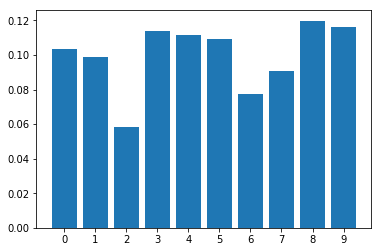

For a good model this should look nearly uniform.
If that is not the case, you are experiencing a mode collapse
which is a common problem for GANs
WGAN Inception Score:  6.75997191223102
GAN perfomance:
The margin distribution:


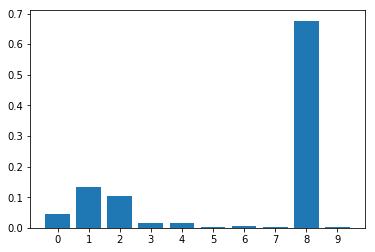

For a good model this should look nearly uniform.
If that is not the case, you are experiencing a mode collapse
which is a common problem for GANs
GAN Inception Score:  1.1767441206159608


In [ ]:
from scipy.stats import entropy
# you can use entropy(dist_1,dist_2) to compute KL-Divergence between
# dist_1 and dist_2


n_img = 100 # times batch_size

preds_list = np.zeros((batch_size*n_img,10))

def inceptionScore(generator):
    with torch.no_grad():
        for i in range(n_img):
            z = Variable(Tensor(np.random.normal(0, 1, (batch_size, latent_dim))))
            gens = generator(z)
            preds = F.softmax(classifier(gens), dim = 1)
            preds_list[i*batch_size:(i+1)*batch_size]= preds.cpu()
            
    margin_dist = np.mean(preds_list, axis = 0)
    
    plt_pos = [i for i in range(10)]
    print('The margin distribution:')
    plt.bar(plt_pos, margin_dist, tick_label = plt_pos)
    plt.show()
    print('For a good model this should look nearly uniform.')
    print('If that is not the case, you are experiencing a mode collapse')
    print('which is a common problem for GANs')
    
    scores = []
    for i in range(preds_list.shape[0]):
        label_dist = preds_list[i,:]
        scores.append(entropy(label_dist, margin_dist))
    return np.exp(np.mean(scores))
print('WGAN perfomance:')
print("WGAN Inception Score: ", inceptionScore(w_generator))
print('GAN perfomance:')
print("GAN Inception Score: ", inceptionScore(generator))
